In [ ]:
#importing libraries
import random
import matplotlib.pyplot as plt
import pandas as pd

### Setting up the game

In [ ]:
import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

### Defining card and deck: implement shuffle and peak

In [ ]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

## Define logic for evaluating the value of the dealer's hand.

In [ ]:
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the 
        # dealer's hand value closer to the [17, 21] range
        
        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17. 
        
        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

## Define logic for evaluating the value of the player's hand.

In [ ]:
"""defining the logic for aces as you know that an ace can be 1 or 11 depending on how close you are to 21. 
we define that if player gets an ace, our num_ace adds 1 and the card value for ace will equal ace=1 else use the current/default card value.
The for_loop will run only if you get an ace, otherwise you get the default card value (e.g,queen,king, etc..)
THEN we define that if num_ace > 0, we use a while loop--> create an ace counter = 0, if num_ace > ace_counter then we will initiate our while_loop.
Now we will use_eleven = use_one + 10, since we already have ace = 1 value added (EX, if we have (card 4 + 1_ace = use_one) and we get another ace, we will use_11 for the next
ace_value, meaning we will have total of 15 points). Now we will not use_elven if our combined value is greater than 21 because the dealer will automatically win. We will use 
eleven ONLY if our use_eleven >= 18 and less than 21 we will use the value in use_elven. If the use_eleven value is less than 18 then our use_one = use_eleven.
"""

def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for the dealer's turn.

In [ ]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

### Main Blackjack play_game() function.

In [ ]:
"""
Defining the blackjack game: We starting with TWO decks, 1000 CASH, and 100 BETS. We shuffle the cards before beginning using the shuffle function. 
We set the player cash equal to the starting cash. We set conditions with WHILE_LOOP, the player should have cash > 0, and rounds played are LESS than 100.
We define player_value = player_hand in the beginning. If the player_value >21, the player automatically loses and $100 is deducted from player_cash. If player_value
is equal to 21, we add $100 to player's cash otherwise, we change it to the dealer's turn. Same rule applies to the dealer when dealer_value =21 and > 21. 
Now in a case when =21 or >21 is not the case for dealer and the player we will determine which player OR the dealer is closer to 21 wins the game.
IF THERE IS A TIE, then nothing happens. At the end of the round, we will put away the cards in the deck and reshuffle the deck. We also subtract the player and 
dealer current cash value from the starting cash.
"""

def play_game(player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        # The current policy does not care about dealer's upcard.
        #dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= 100
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += 100
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += 100
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= 100
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += 100
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= 100
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns net gains/losses of playing
    return player_cash - start_cash

### Simulate Discrete Policy + Graph Results

In [ ]:
"""
We implement a policy that states that if hand >=18, the player and dealer will stand, otherwise hit. (NO CONTINOUS ACTION)

"""
def discrete_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 18, stand. Otherwise, hit.
    while player_value < 18:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

### Run 100,000 games with just 1 round in each to approximate average gain/loss per round.

In [ ]:
"""
We run 100k simulations to calculate our net avg cash, given the discrete policy of hitting if hand value is < 18 then the player hits.
"""
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(discrete_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

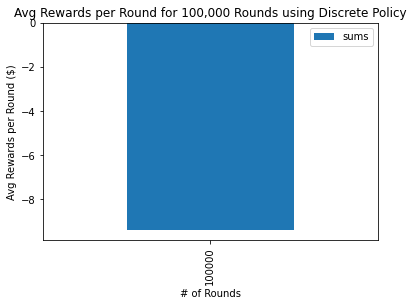

In [ ]:
"""
We see below that after 100k simulations, on average we lose maximum of $10 per round using the discrete policy.
"""
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Discrete Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Discrete Policy")

plt.show()

### Simulate Stochastic Policy + Graph Results: define what player should do on their turn.

In [ ]:
"""
If a player value is less than 18 and stand is FALSE, and the percent value is less than 80% we HIT and append to the deck by adding another card, otherwise
we just STAND. If player_value >= 18 BUT less than 21, and percentage is > 80% so we HIT (This is the reason we lose money on this policy).
"""

def stochastic_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Stochastic Policy
    # If hand >= 18: 80% Stand, 20% Hit
    # Else: 80% Hit, 20% Stand
    
    stand = False
    while player_value < 18 and stand == False:
        percent = random.randint(1, 10)
        if percent <= 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)
        else:
            # stand
            stand = True
    
    if stand:
        return player_value, player_hand, deck
    
    # player_value is now >= 18.
    if player_value < 21:
        percent = random.randint(1, 10)
        if percent > 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)        
            
        # else: Do nothing, stand.
    # else: player_value is 21 or higher, so we must stand in both cases.
    
    return player_value, player_hand, deck

### Run 100,000 games with just 1 round in each to approximate average gain/loss per round.

In [ ]:
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(stochastic_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

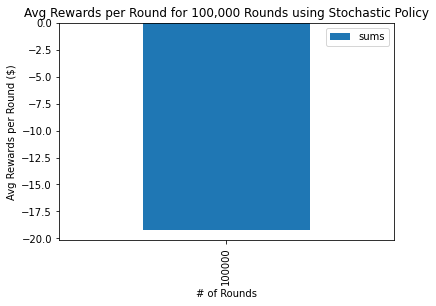

In [ ]:
"""
We see here that our net avg LOSS is $18 per 100K rounds due to the stochastic policy of 80% of hitting if player_value is less than 21 and greater than 18.

"""

# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Stochastic Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Stochastic Policy")

plt.show()